## Dwipam Katariya

Imagine you are given a plot of land to farm that is 10,000 acres. You know nothing about the land.
You have 4 seasons a year in which you can plant and 20 different crops to test out to find the
optimal planting time, crop and location. Each crop has a different price it sells for, the same cost to
farm and a different output depending on the plot of land/time of year in which it is planted. You have
the money to run up to 200 tests (one test is planting one acre with one crop in one season) per year
for 10 years. How would you build an algorithm that would suggest the best 200 tests for each
year/season period to maximize your profit [output x (price – cost)]? Please provide pseudocode for
this exercise along with comments/explanation.

- Used MCMC opimization, random sampling, could have used greedy or UCB.
- Alogirthm:
    - For first year choose 200 tests randomly to plant uniformly over seasons. i,e. 50 per season
    - Observe profit with output from Normal distribution and fixed Price.
    - Select top x% from posterior distribution.
    - Update parameters of top x%.
    - Sample 200-x% remaining samples.
    - Repeat

Assumptions:
    - Output is generated with Normal distribution.
    - Mean of seasons for every sample for the Output are different.
    - As prior is also Normal distribution, I have used Conjugate priors to update prior based on Likelihood.  

I estimate the mean as I see the data.
If you see the ouput, Expected price goes on increasing as we increase number of years. As season 4 has highest mean,number of tests conducted increases gradually.
I have not calculated regrates, as it can be easily done taking the max profit and difference from all the profits. For now my motive is just show how profit can be optimized.

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [19]:
class Type(object):
    '''Optimize per season. Explore 50% per year and exploit remaining time.
    Assume prior of every crop is normally distributed per season and non-constant prior per season with known sd'''
    def __init__(self,acres, crops, seasons):
        self.acres = acres
        self.crops = crops
        self.seasons = seasons
        self.output = [[np.random.normal(loc = 50.0+(5*j),scale=2.0) for i in range(self.acres*self.crops)] for j in range(seasons)]
        self.cost = np.repeat(10,len(np.concatenate(self.output)))
        self.price = [np.random.normal(loc = 10.0,scale = 2.0) for i in range(self.crops)]
        self.data = pd.DataFrame({'Crop_Acre':np.concatenate([np.repeat(range(1,acres+1),crops) for i in range(seasons)]),
                                               'crop':np.concatenate([np.concatenate([np.repeat(i,acres)for i in range(1,crops+1)])for j in range(seasons)]),
                                'Seasons': np.concatenate([np.repeat(i,crops*acres)for i in range(1,seasons+1)]),
                                'output': np.concatenate(self.output),'cost':self.cost})
        plt.figure(1)
        plt.rcParams["figure.figsize"] = [15,5]
        fig, axs = plt.subplots(ncols=1,sharex = True,sharey = True)
        for i in range(len(self.output)):
            sns.distplot(self.output[i],ax=axs,axlabel="Normal Distribution for Outputs for Seasons 1 - Seasons 4")
        #As price and cost are constants, and it won't change over time we don't need to plot the distribution. 

In [85]:
np.random.seed(seed=200)
class optimize(object):
    def __init__(self,Type,years):
        self.price = np.repeat(10,len(Type.price))
        self.plant = []
        self.profit = []
        self.season = []
        self.Type = Type
        self.years = years
        self.Type.data['muOutput'] = np.concatenate([np.repeat(50,(self.Type.acres*self.Type.crops)) 
                                                     for i in range(self.Type.seasons)])
        self.Type.data['sdOutput'] = np.concatenate([np.repeat(2.0,(self.Type.acres*self.Type.crops)) 
                                                     for i in range(self.Type.seasons)])
        self.Type.data['outputPost'] = np.repeat(0,self.Type.data.shape[0])
        self.old_plantation = pd.DataFrame(columns = self.Type.data.columns.values.tolist())
    def optimize(self):
        new_plantation = self.Type.data.sample(n=200)
        mn = [];sm = []; cnt = []
        for year in range(self.years):
            cnt.append(new_plantation['Seasons'].value_counts())
            if self.old_plantation.shape[0]>=200:
                new_plantation = self.old_plantation
                self.old_plantation = pd.DataFrame(columns = self.Type.data.columns.values.tolist())
            o_a = np.array(map(lambda x:np.random.normal(loc=new_plantation.iloc[x]['muOutput'],
                                                         scale = new_plantation.iloc[x]['sdOutput']),
                               range(len(new_plantation['muOutput']))))
            p_a = np.array(map(lambda x:np.random.normal(x),self.price))
            profitPosterior = map(lambda x: o_a[x]*
                                  (self.Type.price[int(new_plantation.iloc[x]['crop']-1)]-new_plantation.iloc[x]['cost']),
                          range(new_plantation.shape[0]))
            topPlantation = np.array(profitPosterior).argsort()[-150:]
            mn.append(np.sum(np.array(profitPosterior)))
            sm.append(np.mean(np.array(profitPosterior)))
            new_plantation.iloc[topPlantation,new_plantation.columns.get_loc('outputPost')] = o_a[topPlantation]
            new_plantation = new_plantation.iloc[topPlantation]
            new_plantation['muOutput'] = self.updateParam(new_plantation)
            self.Type.data.loc[new_plantation.index,'muOutput'] = new_plantation['muOutput'].tolist()
            #Plant crop for the location and season and update it's profit.
            new_plantation = new_plantation.append(self.exploit(self.explore(new_plantation)))
        fig, axs = plt.subplots(ncols=2)
        axs[0].set_ylabel("Total Profit for the Year");axs[0].set_xlabel("Year");axs[0].plot(mn)
        axs[1].set_ylabel("Mean Profit for the Year");axs[1].set_xlabel("Year");axs[1].plot(sm)
        ax = pd.DataFrame(cnt,index = range(self.years)).plot(title="Total tests conducted per season over 10 years")
        ax.set(xlabel="Years", ylabel="Tests")
    def explore(self,old_data):
        return self.exploit(self.Type.data[~self.Type.data.index.isin(old_data.index)])
    def exploit(self,new_data):
        return new_data.sample(n=50)
    def updateParam(self,plantations):
        return map(lambda x:self.Conjugate(plantations.loc[x,'outputPost'],2.0,plantations.loc[x,'output'],2.0),plantations.index)
    def Conjugate(self,x,sig0,prevMu, prevSig): 
        ''' known sigma '''
        muPost = ((prevSig*x) + (sig0**2 * prevMu))/(prevSig + sig0**2)
        sigPost = (prevSig*(sig0**2))/(prevSig+(sig0**2))
        return muPost

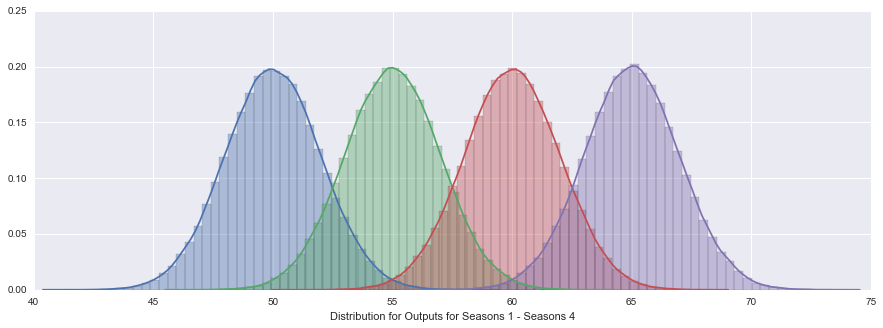

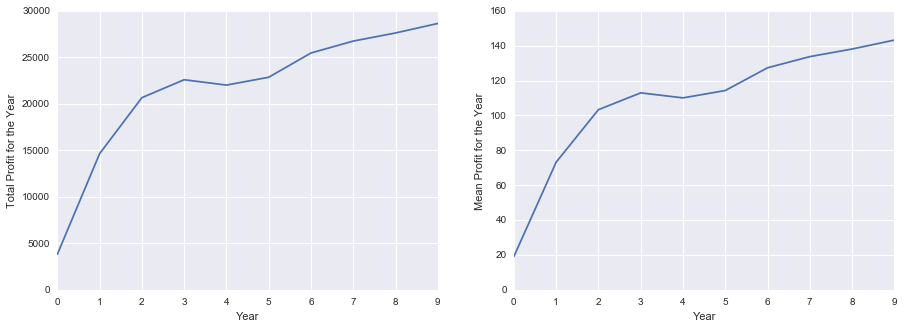

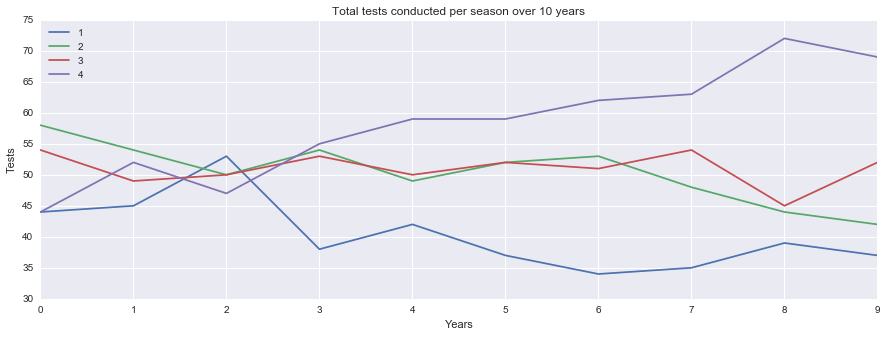

In [86]:
 T = Type(10000,20,4)
o = optimize(T,10)
o.optimize()

In the above plots for Seasons, you can see that sample tests/seasons output has different probability distribution and Season 4 having maximum mean. This means as we estimate the mean, season 4 should have higher samples test that other samples. This is what we observe in the above plot. Number of test allocated to season 4 goes on increasing, while for season 1 goes on decreasing. For season 2 and season 3 it oscillates, but eventually for season 3 goes higher than season 2.